# SWEM (Simple Word Embedding-based Model)

Toma los embeddings y aplica operaciones de Pooling para obtener una representación fija de un documento
Se pueden emplear diferentes técnicas para obtener Embeddings y diferentes modelos de clasificación.

* SWEM-aver:
Hace un promedio de los embeddings

* SWEM-max
Selecciona el valor máximo en cada dimensión del embedding

In [1]:
import sys
import os
import pandas as pd

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from src.trainers.utils import build_datasets
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.2,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

Train: 23.22%
Test: 2.90%
Val: 2.90%
(15688, 2)
(1961, 2)
(1962, 2)


In [5]:
from src.preprocesamiento.nlp_spacy import Tokenizer

tokenizer = Tokenizer()

dataset_train_tokenized = {}
dataset_val_tokenized = {}
dataset_test_tokenized = {}

dataset_train_tokenized['tokens'] = tokenizer.tokenize(dataset_train['text'], True)
dataset_val_tokenized['tokens'] = tokenizer.tokenize(dataset_val['text'], True)
dataset_test_tokenized['tokens'] = tokenizer.tokenize(dataset_test['text'], True)

dataset_train_tokenized['polarity'] = dataset_train['polarity']
dataset_val_tokenized['polarity'] = dataset_val['polarity']
dataset_test_tokenized['polarity'] = dataset_test['polarity']

Modelo cargado: es_core_news_sm


100%|██████████| 1961/1961 [00:01<00:00, 1175.94it/s]


## Entrenar con modelo SVM

In [6]:
from src.trainers.utils import SVMModelArgs
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

svm_model_args = SVMModelArgs()

### Hiperparámetros

In [7]:
import numpy as np

list_pooling = ["aver", "max"]
list_kernel = ["linear", "rbf"]
list_C = np.logspace(-2, 0.5, 5)
print(list_C)

[0.01       0.04216965 0.17782794 0.74989421 3.16227766]


In [8]:
best_accuracy = -1

In [9]:
from src.trainers.utils import save_model
from src.trainers.utils import save_metrics
from src.trainers.train_swem import train_swem
from constants.constants_tiktok import SWEM_MODEL_PATH, TIKTOK_SWEM_METRICS_PATH

for pooling in list_pooling:
    for kernel in list_kernel:
        for C in list_C:
            svm_model_args.kernel = kernel
            svm_model_args.C = C
            model, metrics = train_swem(
                dataset_train_tokenized,
                dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                pooling=pooling,
                classifier="svm",
                model_args=svm_model_args
            )
            print(f"[SWEM SVM {pooling} {kernel} {C:.2f}] acc: {metrics['accuracy']:.4f}")
            save_metrics(metrics, TIKTOK_SWEM_METRICS_PATH)
            if metrics['accuracy'] > best_accuracy:
                best_accuracy = metrics['accuracy']
                save_model(model, SWEM_MODEL_PATH)

[SWEM SVM aver linear 0.01] acc: 0.6035
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl
[SWEM SVM aver linear 0.04] acc: 0.6050
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl
[SWEM SVM aver linear 0.18] acc: 0.6070
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl
[SWEM SVM aver linear 0.75] acc: 0.6075
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl
[SWEM SVM aver linear 3.16] acc: 0.6081
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl
[SWEM SVM aver rbf 0.01] acc: 0.5963
[SWEM SVM aver rbf 0.04] acc: 0.6203
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl
[SWEM SVM aver rbf 0.18] acc: 0.6300
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\ti

## Entrenar con modelo LR

In [10]:
from src.trainers.utils import LRModelArgs

lr_model_args = LRModelArgs()

### Hiperparámetros

In [11]:
import numpy as np

list_pooling = ["aver", "max"]
list_solver_l1 = ["saga"]
list_solver_l2 = ["lbfgs", "saga"]
list_C = np.logspace(-4, 1, 20)
print(list_C)

[1.00000000e-04 1.83298071e-04 3.35981829e-04 6.15848211e-04
 1.12883789e-03 2.06913808e-03 3.79269019e-03 6.95192796e-03
 1.27427499e-02 2.33572147e-02 4.28133240e-02 7.84759970e-02
 1.43844989e-01 2.63665090e-01 4.83293024e-01 8.85866790e-01
 1.62377674e+00 2.97635144e+00 5.45559478e+00 1.00000000e+01]


### Penalty L2

In [12]:
for pooling in list_pooling:
    for solver in list_solver_l2:
        for C in list_C:
            lr_model_args.penalty="l2" 
            lr_model_args.C = C
            lr_model_args.max_iter = 1000
            lr_model_args.solver = solver
            
            model, metrics = train_swem(
                dataset_train_tokenized,
                dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                pooling=pooling,
                classifier="lr",
                model_args=lr_model_args
            )
            print(f"[SWEM LR l2 {pooling} {solver} {C:.2f}] acc: {metrics['accuracy']:.4f}")
            save_metrics(metrics, TIKTOK_SWEM_METRICS_PATH)
            if metrics['accuracy'] > best_accuracy:
                best_accuracy = metrics['accuracy']
                save_model(model, SWEM_MODEL_PATH)

c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5831


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5831


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5841


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5887


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5933


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5973


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.00] acc: 0.5989


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.01] acc: 0.6045


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.01] acc: 0.6065


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.02] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.04] acc: 0.6040


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.08] acc: 0.6045


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.14] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.26] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.48] acc: 0.6014


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 0.89] acc: 0.6019


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 1.62] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 2.98] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 5.46] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver lbfgs 10.00] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5836


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5831


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5841


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5882


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5938


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5968


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.00] acc: 0.5994


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.01] acc: 0.6045


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.01] acc: 0.6060


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.02] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.04] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.08] acc: 0.6050


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.14] acc: 0.6040


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.26] acc: 0.6035


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.48] acc: 0.6035


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 0.89] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 1.62] acc: 0.6024


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 2.98] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 5.46] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 aver saga 10.00] acc: 0.6040


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5133


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5291


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5474


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5627


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5785


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5780


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.00] acc: 0.5790


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.01] acc: 0.5759


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.01] acc: 0.5770


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.02] acc: 0.5780


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.04] acc: 0.5754


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.08] acc: 0.5759


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.14] acc: 0.5744


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.26] acc: 0.5724


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.48] acc: 0.5744


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 0.89] acc: 0.5729


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 1.62] acc: 0.5724


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 2.98] acc: 0.5734


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 5.46] acc: 0.5729


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max lbfgs 10.00] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5127


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5296


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5474


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5632


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5780


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5790


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.00] acc: 0.5795


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.01] acc: 0.5759


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.01] acc: 0.5775


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.02] acc: 0.5765


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.04] acc: 0.5765


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.08] acc: 0.5754


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.14] acc: 0.5734


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.26] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.48] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 0.89] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 1.62] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 2.98] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 5.46] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l2 max saga 10.00] acc: 0.5719


### Penalty L1

In [13]:
for pooling in list_pooling:
    for solver in list_solver_l1:
        for C in list_C:
            lr_model_args.penalty="l1" 
            lr_model_args.C = C
            lr_model_args.max_iter = 1000
            lr_model_args.solver = solver
            
            model, metrics = train_swem(
                dataset_train_tokenized,
                dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                pooling=pooling,
                classifier="lr",
                model_args=lr_model_args
            )
            print(f"[SWEM LR l1 {pooling} {solver} {C:.2f}] acc: {metrics['accuracy']:.4f}")
            save_metrics(metrics, TIKTOK_SWEM_METRICS_PATH)
            if metrics['accuracy'] > best_accuracy:
                best_accuracy = metrics['accuracy']
                save_model(model, SWEM_MODEL_PATH)

c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 aver saga 0.00] acc: 0.3874


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.01] acc: 0.5194


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.01] acc: 0.5622


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.02] acc: 0.5902


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.04] acc: 0.5989


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.08] acc: 0.5968


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.14] acc: 0.5984


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.26] acc: 0.6009


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.48] acc: 0.6009


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 0.89] acc: 0.6030


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 1.62] acc: 0.6035


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 2.98] acc: 0.6035


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 5.46] acc: 0.6040


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 aver saga 10.00] acc: 0.6040


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 max saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 max saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 max saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 max saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 max saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[SWEM LR l1 max saga 0.00] acc: 0.3333


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.00] acc: 0.4715


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.01] acc: 0.5229


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.01] acc: 0.5550


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.02] acc: 0.5683


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.04] acc: 0.5729


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.08] acc: 0.5719


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.14] acc: 0.5714


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.26] acc: 0.5734


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.48] acc: 0.5714


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 0.89] acc: 0.5703


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 1.62] acc: 0.5714


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 2.98] acc: 0.5714


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 5.46] acc: 0.5714


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[SWEM LR l1 max saga 10.00] acc: 0.5714


## Modelo con mayor accuracy

In [14]:
# Seleccionar los hiperparámetros que generan mayor accuracy
df_metrics = pd.read_csv(TIKTOK_SWEM_METRICS_PATH)

best_acc = df_metrics.loc[df_metrics['accuracy'].idxmax()]
print(best_acc)

accuracy           0.658002
recall             0.658002
precision          0.656238
f1_score           0.656421
model                  SWEM
classifier              svm
pooling                aver
penalty                 NaN
kernel                  rbf
regularization     3.162278
max_iter                NaN
solver                  NaN
embedding_dim           100
train_time        29.637008
Name: 9, dtype: object


Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\swem_model.pkl

Simple Word Embedding-based Model
Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       677
           1       0.60      0.63      0.62       620
           2       0.74      0.73      0.73       664

    accuracy                           0.69      1961
   macro avg       0.69      0.68      0.68      1961
weighted avg       0.69      0.69      0.69      1961

Matriz de confusión


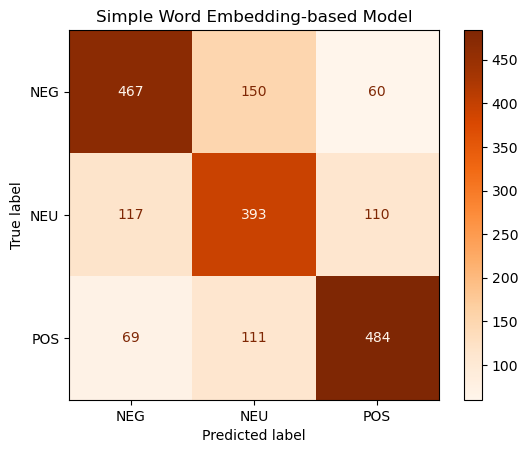

{'accuracy': 0.6853646098929118,
 'recall': 0.6853797965322755,
 'precision': 0.6841982022529534,
 'f1_score': 0.6845520812319448}

In [16]:
from src.trainers.utils import load_model
from src.trainers.train_swem import evaluate_model

# Evaluar modelo con datos de prueba
model = load_model(SWEM_MODEL_PATH)
metrics = evaluate_model(
    model, 
    dataset_test_tokenized,
    "Simple Word Embedding-based Model",
    EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    best_acc['pooling'],
)
display(metrics)